# Constructing Bivariate Confidence Intervals

This repository is a collection of utilites for computing histograms and confidence intervals on bivariate data. Functions are broken out into groups:

### Testing distributions
- `points = testDistributions(distN, Npoints)`
    
### Bivariate histogram utilities
- `[Xlist, Ylist] = autogridBivariate(points, varargin)`
- `binCenters = edgesToCenters(binEdges)`
- `binEdges = centersToEdges(binCenters)`

### Contour generation utilities
- `M = contourBivariateDistribution(P, Xlist, Ylist, alpha)`
- `M = calibratedContour(P, Xlist, Ylist, alpha, points)`
- `M = repairContour(M)`
- `h = plotContour(M, varargin)`
- `poly = contourToPolygon(M)`

### Generating PDFs by smoothing histograms
- `N = smoothHist(N, smoothBins)`
- `P = smoothHistogramDensityEstimate(points, Xedges, Yedges, varargin)`
- `M = histogramConfidence(points, alpha, varargin)`

### Generating PDFs with Gaussian Kernel Density Estimation
- `P = bivariateKDE(points, Xlist, Ylist, varargin)`
- `M = kdeConfidence(points, alpha, varargin)`

### Generating PDFs with adaptive bandwidth KDE
- `P = adaptiveBivariateKDE(points, Xlist, Ylist, varargin)`
- `M = adaptiveKdeConfidence(points, alpha, varargin)`

In [1]:
addpath(genpath('~/Code/matlabTools/plotTools'));

## Testing distributions

These are a collection of distributions with varying correlation structure.

In [2]:
%%file testDistributions.m
function p = testDistributions(distN, nPoints)

    switch distN
        case 1
            t = pi*rand(nPoints,1);
            p = [sin(t),cos(t)] + 0.1*randn(nPoints,2);
        case 2
            t = 2*pi*rand(nPoints,1);
            p = [sin(t),cos(t)] + 0.2*randn(nPoints,2);
        case 3
            p = [.1, .5].*randn(nPoints,2);
        case 4
            p = [(randi(2,nPoints,1) - 1.5),zeros(nPoints,1)] + 0.15*randn(nPoints,2);
        case 5
            t = pi*rand(nPoints,1);
            p = [t - pi/2,sin(3*t)] + 0.1*randn(nPoints,2);
        case 6
            p = [(randi(2,nPoints,1) - 1.5),(randi(2,nPoints,1) - 1.5)] + 0.15*randn(nPoints,2);
        case 7
            dSelect = (rand(nPoints,1) > 0.5);
            p1 = [1, 1].*randn(nPoints,2);
            p2 = randn(nPoints,2).*[.1,.5] + [.5,0];
            p = (1-dSelect).*p1 + dSelect.*p2;
        case 8
            p = rand(nPoints,2) - [0.5, 0.5];
    end
end

Created file '/home/joe/Code/matlabTools/bivarConf/testDistributions.m'.


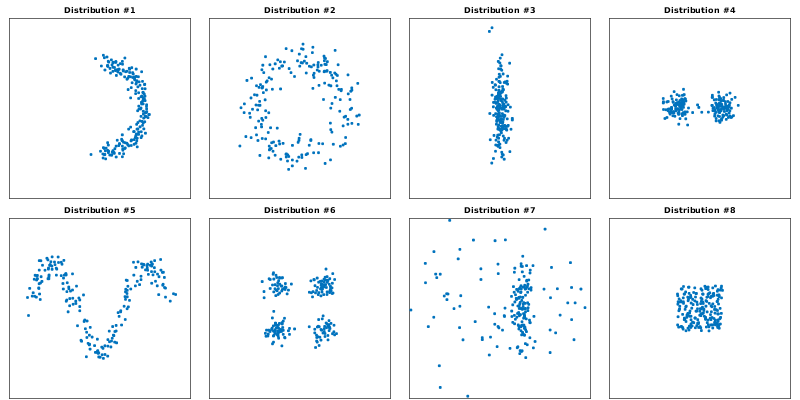

In [3]:
%plot inline -s 800,400 -r 100
tS = tightSubplot(2,4);
nTestDistributions = 8;
for distN = 1:nTestDistributions
    tS.getSubplot(distN);
    Npoints = 200;
    p = testDistributions(distN, Npoints);
    scatter(p(:,1),p(:,2),'.');
    axis equal; box on; xlim([-2 2]); ylim([-2 2]);
    set(gca,'XTick',[],'YTick',[]);
    title(sprintf('Distribution #%d',distN),'FontSize',6);
end

## Bivariate histogram utilities

These functions are useful for all methods.

In [4]:
%%file autogridBivariate.m
%
% autogridBivariate.m
%
% Function for automatically binning or grid-covering bivariate distributions with a uniform grid.
% 
%     points - [N,2] matrix of points to grid over.
%
%     Xlist, Ylist - List of bin edges or centers.
%
% By default returns edges of an optimal binning (in the MSE sense) for bivariate gaussian distribution, 
% based on the extent and distribution of the data. Beyond this parameters can be adjusted as Name/Value 
% pairs.
%
% 'Resolution' - [1,2] matrix of bin spacing in X,Y.
% 'Overspan'   - (default: 1) Positive scalar, length of coverage beyond distribution 
%                 relative to maximum span of data
% 'Ngrid'      - Number of points to include (will return N+1 edges)
% 'BinCenters' - (default: false) If true will return bin center points instead of bin edges.
% 'Upsample'   - Factor to increase Nbins beyond current settings
%
%%
function [Xlist, Ylist] = autogridBivariate(points, varargin)



    nPoints = size(points,1);
    Xmid = (max(points(:,1)) + min(points(:,1)))/2;
    Ymid = (max(points(:,2)) + min(points(:,2)))/2;
    Xspan = (max(points(:,1)) - min(points(:,1)));
    Yspan = (max(points(:,2)) - min(points(:,2)));
    
    % Default values
    binCenters = false;
    upSample = 1;
    overspan = 1;
    % Optimal resolution for a bivariate normal
    rho = corr(points(:,1),points(:,2));
    resolution = 3.504*std(points,[],1)*((1 - rho^2)^(3/8))*(nPoints^(-1/4));
    % Provisional Ngrid
    Ngrid = [ceil((1 + overspan)*Xspan/resolution(1)),ceil((1 + overspan)*Yspan/resolution(2))];
    
    if nargin >= 3
        if mod(nargin-1,2)
            error('Unpaired Name/Value arguments.');
        end
        
        % If Name/Value arguments are present, reset to adjust to those
        for argN = 1:2:(nargin-1)
            if strcmp(varargin{argN},'Resolution')
                resolution = varargin{argN+1};
                % Recalc Ngrid
                Ngrid = [ceil((1 + overspan)*Xspan/resolution(1)),ceil((1 + overspan)*Yspan/resolution(2))];
            elseif strcmp(varargin{argN}, 'Overspan')
                overspan = varargin{argN+1};
                % Recalc Ngrid
                Ngrid = [ceil((1 + overspan)*Xspan/resolution(1)),ceil((1 + overspan)*Yspan/resolution(2))];
            elseif strcmp(varargin{argN}, 'Ngrid')
                Ngrid = varargin{argN+1};
                % Recalc resolution
                resolution = [(1 + overspan)*Xspan/Ngrid(1),(1 + overspan)*Yspan/Ngrid(2)];
            elseif strcmp(varargin{argN}, 'BinCenters')
                binCenters = varargin{argN+1};
            elseif strcmp(varargin{argN}, 'Upsample')
                upSample = varargin{argN+1};
                if upSample > 1
                    Ngrid = round(Ngrid.*upSample);
                    % Recalc resolution
                    resolution = [(1 + overspan)*Xspan/Ngrid(1),(1 + overspan)*Yspan/Ngrid(2)];
                end
            end   
        end
    end
    
    % Calculate lists from grid and resolution
    Xlist = [1:(Ngrid(1)+1)]*resolution(1) - mean([1:(Ngrid(1)+1)]*resolution(1)) + Xmid;
    Ylist = [1:(Ngrid(2)+1)]*resolution(2) - mean([1:(Ngrid(2)+1)]*resolution(2)) + Ymid;
    
    % If directed to get centers instead of edges, convert to centers
    if binCenters
        Xlist = edgesToCenters(Xlist);
        Ylist = edgesToCenters(Ylist);
    end
end

Created file '/home/joe/Code/matlabTools/bivarConf/autogridBivariate.m'.


In [5]:
%%file edgesToCenters.m
%
% Calculates a list of bin centers from a list of bin edges.
%
function binCenters = edgesToCenters(binEdges)

    binCenters = (binEdges(1:(end-1)) + binEdges(2:end))/2;
    
end

Created file '/home/joe/Code/matlabTools/bivarConf/edgesToCenters.m'.


In [6]:
%%file centersToEdges.m
%
% Calculates a list of bin edges from a list of centers.
%
function binEdges = centersToEdges(binCenters)
    eCtrs = [binCenters(1) - (binCenters(2) - binCenters(1));...
             binCenters(:);...
             binCenters(end) + (binCenters(end) - binCenters(end-1))];
    binEdges = eCtrs(1:(end-1)) + diff(eCtrs)/2;
end

Created file '/home/joe/Code/matlabTools/bivarConf/centersToEdges.m'.


### Test histogram bin center to edge conversion

In [7]:
% Test bin center and edge generation
centers = 1:5;
calcEdges = centersToEdges(centers);
regenCenters = edgesToCenters(calcEdges);
fprintf('Centers: \t');
fprintf('%.1f\t\t',centers); 
fprintf('\nEdges: \t   ');
fprintf('%.1f\t\t',calcEdges); 
fprintf('\nRegen Centers: \t');
fprintf('%.1f\t\t',regenCenters);

Centers: 	1.0		2.0		3.0		4.0		5.0		
Edges: 	   0.5		1.5		2.5		3.5		4.5		5.5		
Regen Centers: 	1.0		2.0		3.0		4.0		5.0		

### Test bivariate histogram autobinning

This plot shows sample options for autobinning histograms.

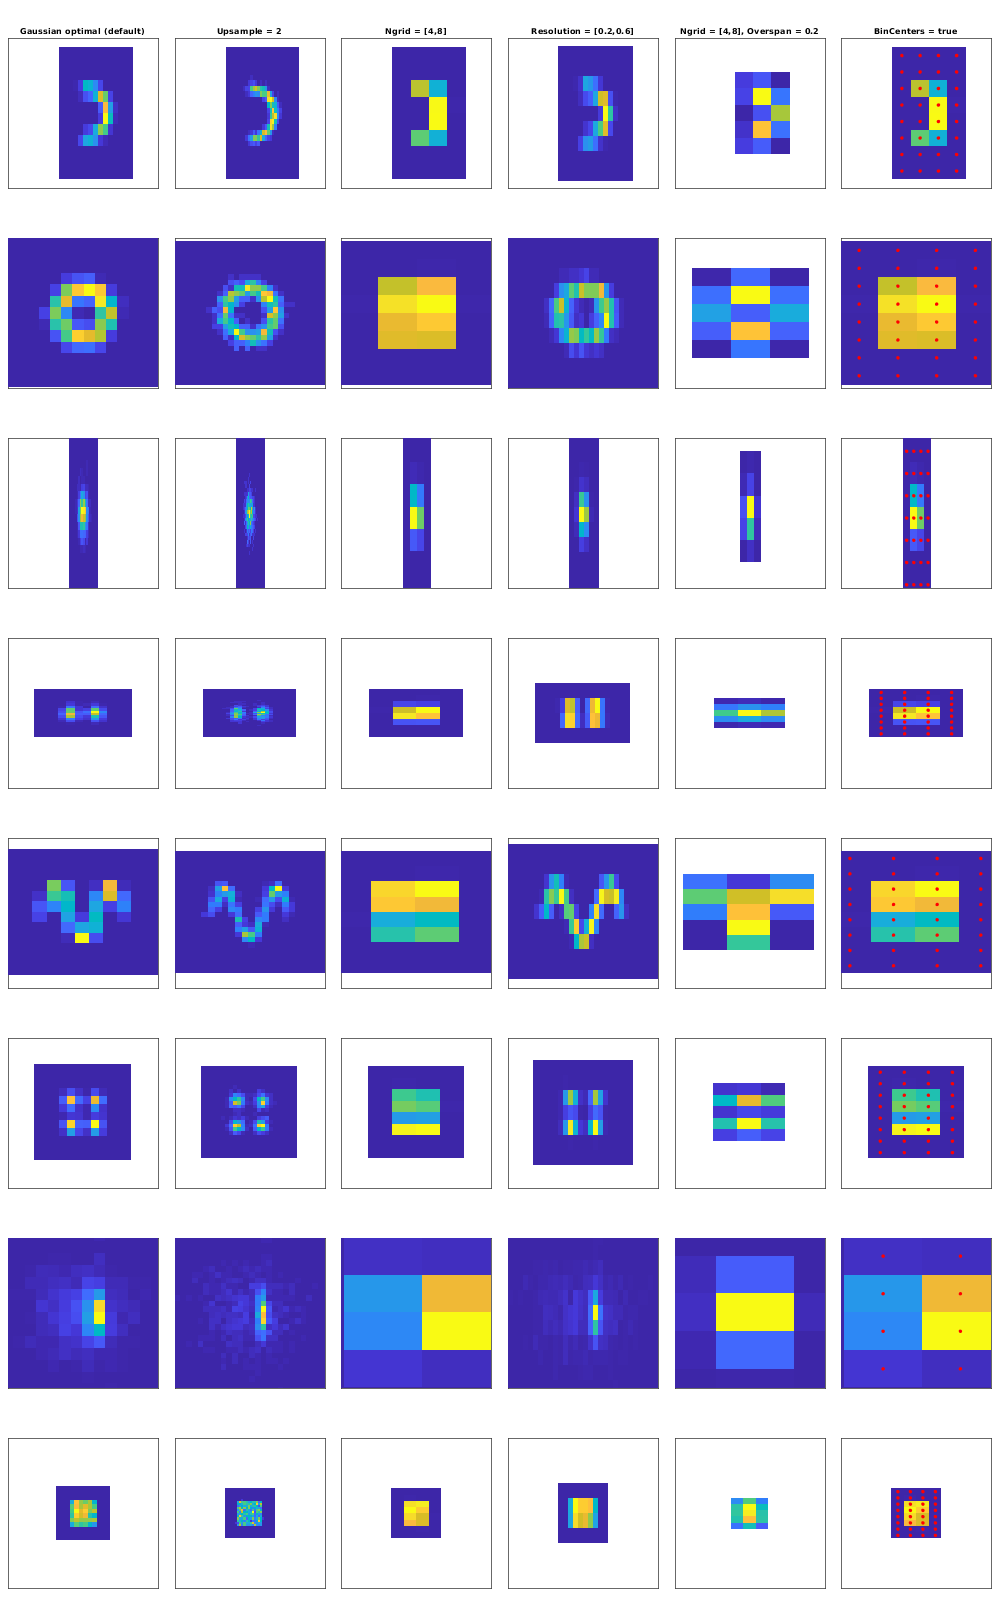

In [8]:
%plot inline -s 1000,1600 -r 100

view = 3;
tS = tightSubplot(nTestDistributions, 6, [.05 .05 .01 .15]);  
for distN = 1:nTestDistributions
    points = testDistributions(distN,1000);
    
    tS.getSubplot(distN, 1);
    [Xedges, Yedges] = autogridBivariate(points);
    N = histcounts2(points(:,1),points(:,2),Xedges,Yedges);
    pseudoColorImage(Xedges,Yedges,N');
    axis equal;  xlim([-view view]); ylim([-view view]); set(gca,'XTick',[],'YTick',[]); 
    if distN == 1
        title('Gaussian optimal (default)','FontSize',6);
    end
    
    tS.getSubplot(distN, 2);
    [Xedges, Yedges] = autogridBivariate(points,'Upsample',2);
    N = histcounts2(points(:,1),points(:,2),Xedges,Yedges);
    pseudoColorImage(Xedges,Yedges,N');
    axis equal;  xlim([-view view]); ylim([-view view]); set(gca,'XTick',[],'YTick',[]); 
    if distN == 1
        title('Upsample = 2','FontSize',6);
    end
    
    tS.getSubplot(distN, 3);
    [Xedges, Yedges] = autogridBivariate(points, 'Ngrid',[4,8]);
    N = histcounts2(points(:,1),points(:,2),Xedges,Yedges);
    pseudoColorImage(Xedges,Yedges,N');
    axis equal;  xlim([-view view]); ylim([-view view]); set(gca,'XTick',[],'YTick',[]); 
    if distN == 1
        title('Ngrid = [4,8]','FontSize',6);
    end
    
    tS.getSubplot(distN, 4);
    [Xedges, Yedges] = autogridBivariate(points, 'Resolution',[.2,.6]);
    N = histcounts2(points(:,1),points(:,2),Xedges,Yedges);
    pseudoColorImage(Xedges,Yedges,N');
    axis equal;  xlim([-view view]); ylim([-view view]); set(gca,'XTick',[],'YTick',[]); 
    if distN == 1
        title('Resolution = [0.2,0.6]','FontSize',6);
    end
    
    tS.getSubplot(distN, 5);
    [Xedges, Yedges] = autogridBivariate(points, 'Ngrid',[4,8],'Overspan',0.2);
    N = histcounts2(points(:,1),points(:,2),Xedges,Yedges);
    pseudoColorImage(Xedges,Yedges,N');
    axis equal;  xlim([-view view]); ylim([-view view]); set(gca,'XTick',[],'YTick',[]); 
    if distN == 1
        title('Ngrid = [4,8], Overspan = 0.2','FontSize',6);
    end
    
    tS.getSubplot(distN, 6);
    [Xedges, Yedges] = autogridBivariate(points, 'Ngrid',[4,8]);
    N = histcounts2(points(:,1),points(:,2),Xedges,Yedges);
    pseudoColorImage(Xedges,Yedges,N'); hold on;
    [Xedges, Yedges] = autogridBivariate(points, 'Ngrid',[4,8],'BinCenters',true);
    [X,Y] = meshgrid(Xedges,Yedges);
    scatter(X(:),Y(:),'r.');
    axis equal;  xlim([-view view]); ylim([-view view]); set(gca,'XTick',[],'YTick',[]); 
    if distN == 1
        title('BinCenters = true','FontSize',6);
    end
end


## Contour generation utilities

In [9]:
%%file contourBivariateDistribution.m
%
% contourBivariateDistribution.m
%
% Takes a probability distribution P sampled on a grid Xlist x Ylist and 
% draws a contour line at the level (1 - alpha).
%
%%
function M = contourBivariateDistribution(P, Xlist, Ylist, alpha)
    % Ensure the distribution sums to one
    if abs(sum(P(:)) - 1) > 10^-3
        error(sprintf('Input distribution does not sum to one: %0.3f',sum(P(:))));
    end
    sP = sort(P(:),'descend');
    cP = cumsum(sP);
    level = sP(find(cP > (1 - alpha),1));
    
    M = contourc(Xlist,Ylist,P,[level level]);
end

Created file '/home/joe/Code/matlabTools/bivarConf/contourBivariateDistribution.m'.


### Contour calibration

Because PDFs are calculated with smoothing, they're biased toward over-covering the sample distribution. Here we adjust the level of the contour selected until (1 - alpha) of the sample points are contained. This results in a contour shaped by the smooth PDF, but containing the correct number of samples.

In [10]:
%%file calibratedContour.m
%
% calibratedContour.m
%
% Draws a contour line on P as in contourBivariateDistribution.m but then 
% adjusts the level alpha such that (1 - alpha) of sample points are contained
% in the contour. This calculates multiple contours and checks whether points 
% are inside them, so it runs a little slower, but produces much less biased 
% coverage especially with high kernel bandwidths.
%
%%
function M = calibratedContour(P, Xlist, Ylist, alpha, points)
    % Ensure the distribution sums to one
    if abs(sum(P(:)) - 1) > 10^-3
        error(sprintf('Input distribution does not sum to one: %0.3f',sum(P(:))));
    end
    
    sP = sort(P(:),'descend');
    cP = cumsum(sP);
    
    % Search in 2 stages, coarse first
    pointsPerRound = 16;
    alphaList = linspace(2/size(points,1),1-2/size(points,1),pointsPerRound);
    for alphaN = 1:length(alphaList)
        tryAlpha = alphaList(alphaN);

        levels(alphaN) = sP(find(cP > (1 - tryAlpha),1));
        M = contourc(Xlist,Ylist,P,[levels(alphaN) levels(alphaN)]);
        poly = contourToPolygon(M);
        if size(poly,1) > 0
            coverage(alphaN) = nnz(inpolygon(points(:,1),points(:,2),poly(:,1),poly(:,2)))/size(points,1);
        else
            coverage(alphaN) = 0;
        end
    end
    [~, ix] = min(abs((1 - coverage - alpha)));
    % Now do a fine search
    alphaList = linspace(alphaList(max([ix-1,1])),alphaList(min([ix+1,pointsPerRound])),pointsPerRound);
    for alphaN = 1:length(alphaList)
        tryAlpha = alphaList(alphaN);

        levels(alphaN) = sP(find(cP > (1 - tryAlpha),1));
        M = contourc(Xlist,Ylist,P,[levels(alphaN) levels(alphaN)]);
        poly = contourToPolygon(M);
        if size(poly,1) > 0
            coverage(alphaN) = nnz(inpolygon(points(:,1),points(:,2),poly(:,1),poly(:,2)))/size(points,1);
        else
            coverage(alphaN) = 0;
        end
    end
    [~, ix] = min(abs((1 - coverage - alpha)));

    M = contourc(Xlist,Ylist,P,[levels(ix) levels(ix)]); hold on;       
end

Created file '/home/joe/Code/matlabTools/bivarConf/calibratedContour.m'.


### Test contour calibration

This demonstrates the effect of calibrating the contours - returning to the source points used to generate the PDF to find the density level that includes the correct fraction of points. 

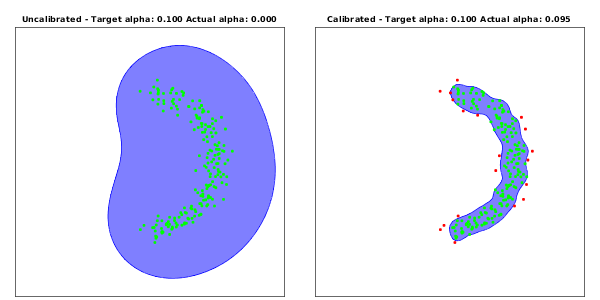

In [11]:
%plot inline -s 600,300 -r 100

tS = tightSubplot(1,2);
tS.getSubplot(1);
points = testDistributions(1, 200);
[Xctrs,Yctrs] = autogridBivariate(points,'Resolution',[.05,.05],'BinCenters',true);
% P = bivariateKDE(points, Xctrs, Yctrs,'ScaleBandwidth', 1);
P = adaptiveBivariateKDE(points, Xctrs, Yctrs,'ScaleBandwidth', 1);

alpha = .1;
M = contourBivariateDistribution(P, Xctrs, Yctrs, alpha);
% M = calibratedContour(P, Xctrs, Yctrs, alpha, points);
h = plotContour(M,'FaceAlpha',0.5,'FaceColor','b','EdgeColor','b'); hold on;

poly = contourToPolygon(M);
in = inpolygon(points(:,1),points(:,2),poly(:,1),poly(:,2));
actualAlpha = 1 - nnz(in)/size(points,1);
scatter(points(find(in==1),1),points(find(in==1),2),'g.');
scatter(points(find(in==0),1),points(find(in==0),2),'r.');
axis equal; box on; xlim([-2 2]); ylim([-2 2]);
set(gca,'XTick',[],'YTick',[]);
title(sprintf('Uncalibrated - Target alpha: %.3f Actual alpha: %.3f',alpha, actualAlpha),'FontSize',6);


tS.getSubplot(2);
[Xctrs,Yctrs] = autogridBivariate(points,'Resolution',[.05,.05],'BinCenters',true);
% P = bivariateKDE(points, Xctrs, Yctrs,'ScaleBandwidth', 1);
P = adaptiveBivariateKDE(points, Xctrs, Yctrs,'ScaleBandwidth', 1);

alpha = .1;
% M = contourBivariateDistribution(P, Xctrs, Yctrs, alpha);
M = calibratedContour(P, Xctrs, Yctrs, alpha, points);
h = plotContour(M,'FaceAlpha',0.5,'FaceColor','b','EdgeColor','b'); hold on;

poly = contourToPolygon(M);
in = inpolygon(points(:,1),points(:,2),poly(:,1),poly(:,2));
actualAlpha = 1 - nnz(in)/size(points,1);
scatter(points(find(in==1),1),points(find(in==1),2),'g.');
scatter(points(find(in==0),1),points(find(in==0),2),'r.');
axis equal; box on; xlim([-2 2]); ylim([-2 2]);
set(gca,'XTick',[],'YTick',[]);
title(sprintf('Calibrated - Target alpha: %.3f Actual alpha: %.3f',alpha, actualAlpha),'FontSize',6);

In [12]:
%%file repairContour.m
%
% Adds curves to the contour matrix M to repair discontinuities at histogram edges.
%
%%
function M = repairContour(M)
    stIX = 1;

    % Protect against empty M's
    if size(M,2) > 1
        discPts = [];
        enIX = stIX + M(2, stIX);
        while (stIX < size(M,2))
            level = M(1,stIX);
            enIX = stIX + M(2,stIX);
            % Detect discontinuities at matrix edges
            if ~isequal(M(:,stIX+1),M(:,enIX))
                discPts = cat(2,discPts,M(:,[stIX+1,enIX]));
            end
            stIX = enIX + 1;
        end
        if size(discPts,2) >= 3
            % Orient the discontinuous points and add them as another curve
            discMean = mean(discPts,2);
            angles = atan2(discPts(2,:) - discMean(2),discPts(1,:) - discMean(1));
            [~,ix] = sort(angles,'ascend');
            M = cat(2,M,[level;length(ix)+1]);
            M = cat(2,M,discPts(:,[ix(1:end),ix(1)]));
        end
    end
end

Created file '/home/joe/Code/matlabTools/bivarConf/repairContour.m'.


In [13]:
%%file plotContour.m
%
% Plots contours from contour matrix using polyshapes. This replaces the draw
% functionality of contourf, so that patch properties can be set more flexibly.
%
% varargin{:} can set any patch property.
%
%%
function h = plotContour(M, varargin)

    M = repairContour(M);

    stIX = 1;
    h = [];
    % Protect against empty M's
    if size(M,2) > 1
        enIX = stIX + M(2, stIX);
        while (stIX < size(M,2))
            enIX = stIX + M(2,stIX);
            M(:,stIX) = NaN;
            stIX = enIX + 1;
        end

        warning('off');
        p = polyshape(M(1,:),M(2,:),'Simplify',true);
        warning('on');
        h = plot(p,varargin{:});
    end
end 

Created file '/home/joe/Code/matlabTools/bivarConf/plotContour.m'.


In [14]:
%%file contourToPolygon.m
%%
% contourToPolygon.m
%
% Parses a contour matrix into polygon syntax, separated by NaNs.
% If there are multiple polygons in the matrix it alternates the orientation of them.
% (This is necessary for inpolygon() to correctly orient to holes.)
%
%%
function poly = contourToPolygon(M)

    % Repair discontinuities
    M = repairContour(M);

    ix = 1;
    poly = [];
    oddPath = true;
    while ix < size(M,2)
        span = M(2,ix);
        xv = M(1,(ix+1):(ix+span));
        yv = M(2,(ix+1):(ix+span));
        
        series = [xv(:),yv(:)];
        if size(series,1) > 2
            % Orient the curve
            seriesDiff = diff(series([1:end,1],:),1,1);
            seriesDiff(:,3) = 0;
            sd2 = seriesDiff([2:end,1],:);
            cp = cross(seriesDiff,sd2);
            orientation = mean(cp(:,3));

            if ((oddPath && (orientation > 0)) | (~oddPath && (orientation < 0)))
                xv = flip(xv);
                yv = flip(yv);
            end
            poly = cat(1,poly,[xv(:), yv(:)]);
            poly = cat(1,poly,[NaN,NaN]);
        end
        oddPath = ~oddPath;
        ix = ix + span + 1;
    end
end

Created file '/home/joe/Code/matlabTools/bivarConf/contourToPolygon.m'.


### Smoothed histogram method

This method is boneheaded, but works surprisingly well with reasonable assumptions about the histogram binning. It bins bivariate data in a 2D histogram, optionally smooths it with a gaussian function (defined over # of bins, not data units) and then calculates the contour of the 1 - alpha density line.

In [15]:
%%file smoothHist.m
function N = smoothHist(N, smoothBins)

    if smoothBins > 0
        % Make a gaussian kernel out to 5*sigma
        sig = 5;
        kernelSize = ceil([sig*smoothBins,sig*smoothBins]);
        z = fspecial('gaussian', kernelSize, smoothBins);

        % Convolve histogram counts with the gaussian
        N = conv2(N,z,'same');
    end
end

Created file '/home/joe/Code/matlabTools/bivarConf/smoothHist.m'.


In [16]:
%%file smoothHistogramDensityEstimate.m
%
% smoothHistogramDensityEstimate.m
%
% Function to calculate and smooth a histogram with given edges.
%
%%
function P = smoothHistogramDensityEstimate(points, Xedges, Yedges, varargin)
    smoothBins = 0;
    for argN = 1:2:(nargin-3)
        if strcmp(varargin{argN},'SmoothBins')
            smoothBins = varargin{argN+1};
        end
    end
    
    N = histcounts2(points(:,1),points(:,2),Xedges,Yedges); 
    N = smoothHist(N, smoothBins);
    P = N'./(sum(N(:)));
end

Created file '/home/joe/Code/matlabTools/bivarConf/smoothHistogramDensityEstimate.m'.


In [17]:
%%file histogramConfidence.m
%%
% histogramConfidence.m
%
% Uses gaussian smoothing of a histogram to find a confidence region. 
% 
% varargin{:} - Specifies optional arguments to autogridBivariate.m
%
%%
function M = histogramConfidence(points, alpha, varargin)
    [Xedges, Yedges] = autogridBivariate(points, 'BinCenters', false, varargin{:});
    P = smoothHistogramDensityEstimate(points, Xedges, Yedges, varargin{:});
    Xctrs = edgesToCenters(Xedges); Yctrs = edgesToCenters(Yedges);
    % M = contourBivariateDistribution(P, binCenters{1}, binCenters{2}, alpha);
    M = calibratedContour(P, Xctrs, Yctrs, alpha, points);
end

Created file '/home/joe/Code/matlabTools/bivarConf/histogramConfidence.m'.


### Testing histogram confidence method

Here we use the default optimal binning, then upsample by a factor of 3, and smooth with a gaussian kernel 1 bin wide.

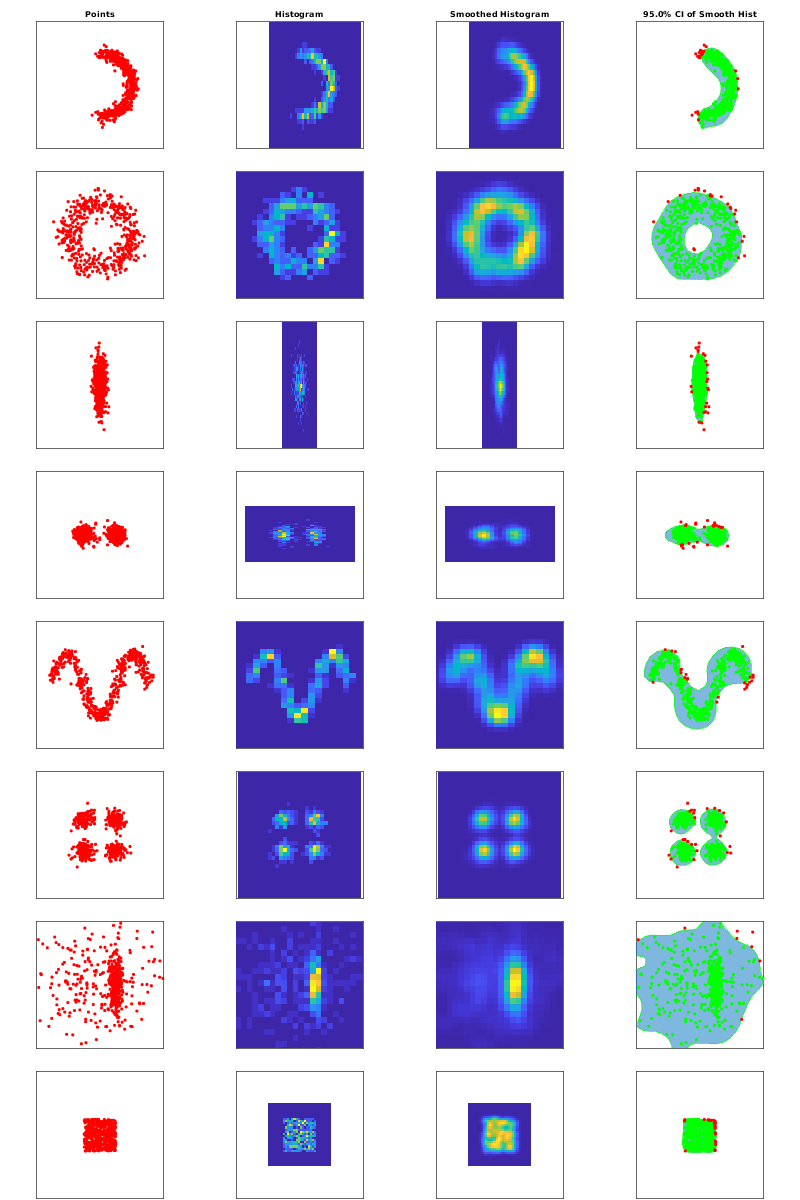

In [18]:
%plot inline -s 800,1200 -r 100

tS = tightSubplot(8,4,[.05 .05 .01 .15]);
fs = 6;
for distN = 1:nTestDistributions
    points = testDistributions(distN,500);

    tS.getSubplot(distN, 1);
    scatter(points(:,1),points(:,2),'r.');
    axis equal; box on; xlim([-2 2]); ylim([-2 2]);
    set(gca,'XTick',[],'YTick',[]);
    if distN == 1
        title('Points','FontSize',fs);
    end

    tS.getSubplot(distN, 2);
    [Xedges,Yedges] = autogridBivariate(points, 'BinCenters', false,'Upsample',3);
    N = histcounts2(points(:,1),points(:,2),Xedges,Yedges);
    pseudoColorImage(Xedges,Yedges,N'); hold on;
    axis equal; box on; xlim([-2 2]); ylim([-2 2]);
    set(gca,'XTick',[],'YTick',[]);
    if distN == 1
        title('Histogram','FontSize',fs);
    end

    tS.getSubplot(distN, 3);
    [Xedges,Yedges] = autogridBivariate(points, 'BinCenters', false,'Upsample',3);
    N = histcounts2(points(:,1),points(:,2),Xedges,Yedges);
    binCenters = {edgesToCenters(Xedges),edgesToCenters(Yedges)}; 
    smoothBins = 1;
    N = smoothHist(N, smoothBins);
    P = N'./sum(N(:));
    pseudoColorImage(binCenters{1},binCenters{2},P);
    axis equal; box on; xlim([-2 2]); ylim([-2 2]);
    set(gca,'XTick',[],'YTick',[]);
    if distN == 1
        title('Smoothed Histogram','FontSize',fs);
    end

    tS.getSubplot(distN, 4);
    % alpha = 1 - .683; % Standard deviation
    alpha = 0.05;
    M = histogramConfidence(points, alpha, 'SmoothBins',1.5, 'Upsample',3);
    h = plotContour(M,'FaceAlpha',0.5,'EdgeColor','g'); hold on;

    poly = contourToPolygon(M);
    in = inpolygon(points(:,1),points(:,2),poly(:,1),poly(:,2));
    scatter(points(find(in==1),1),points(find(in==1),2),'g.');
    scatter(points(find(in==0),1),points(find(in==0),2),'r.');

    axis equal; box on; xlim([-2 2]); ylim([-2 2]);
    set(gca,'XTick',[],'YTick',[]);
    if distN == 1
        title(sprintf('%.1f%% CI of Smooth Hist',100*(1-alpha)),'FontSize',fs);
    end
end

### Kernel Density Estimation Method

This method smooths points with a gaussian kernel. The kernel bandwidth is set to the gaussian optimal, per:

> Bowman, Adrian W., and Adelchi Azzalini. _Applied smoothing techniques for data analysis: the kernel approach with S-Plus illustrations._ Vol. 18. OUP Oxford, 1997.

A resolution parameter specifies how finely to draw the output grid, in data units. 


In [19]:
%%file bivariateKDE.m
%
% bivariateKDE.m
% 
% Computes an estimated PDF by smoothing with a gaussian kernel. By default
% chooses an optimal bandwidth (using Silverman's rule). Bandwidth can be 
% scaled up or down from this optimal by a factor ScaleBandwidth.
%
%%
function P = bivariateKDE(points, Xlist, Ylist, varargin)

    scaleBandwidth = 1;
    for argN = 1:2:(nargin-3)
        if strcmp(varargin{argN},'ScaleBandwidth')
                scaleBandwidth = varargin{argN+1};
        end
    end
        
    [Xgrid,Ygrid] = meshgrid(Xlist,Ylist);
    
    % Estimate bandwidth with Silverman's rule
    sig = mad(points,1,1) / 0.6745;
    N = size(points,1);  d = size(points,2);
    bw = sig * (4/((d+2)*N))^(1/(d+4)) .* scaleBandwidth;
    
    % Calculate the KDE
    [P,xi] = ksdensity(points,[Xgrid(:),Ygrid(:)],'Bandwidth', bw);
    
    % Reshape and normalize
    P = reshape(P,length(Ylist), length(Xlist));
    P = P./sum(P(:));
end

Created file '/home/joe/Code/matlabTools/bivarConf/bivariateKDE.m'.


In [20]:
%%file kdeConfidence.m
%%
% kdeConfidence.m
%
% Uses gaussian kernel density estimation to find a confidence region. 
% 
% varargin{:} - Specifies optional arguments to autogridBivariate.m
%
%%
function M = kdeConfidence(points, alpha, varargin)
    [x, y] = autogridBivariate(points, 'BinCenters', true, varargin{:});
    P = bivariateKDE(points,x,y,varargin{:}); 
    % M = contourBivariateDistribution(P, x, y, alpha);
    M = calibratedContour(P, x, y, alpha, points);
end

Created file '/home/joe/Code/matlabTools/bivarConf/kdeConfidence.m'.


### Testing KDE 

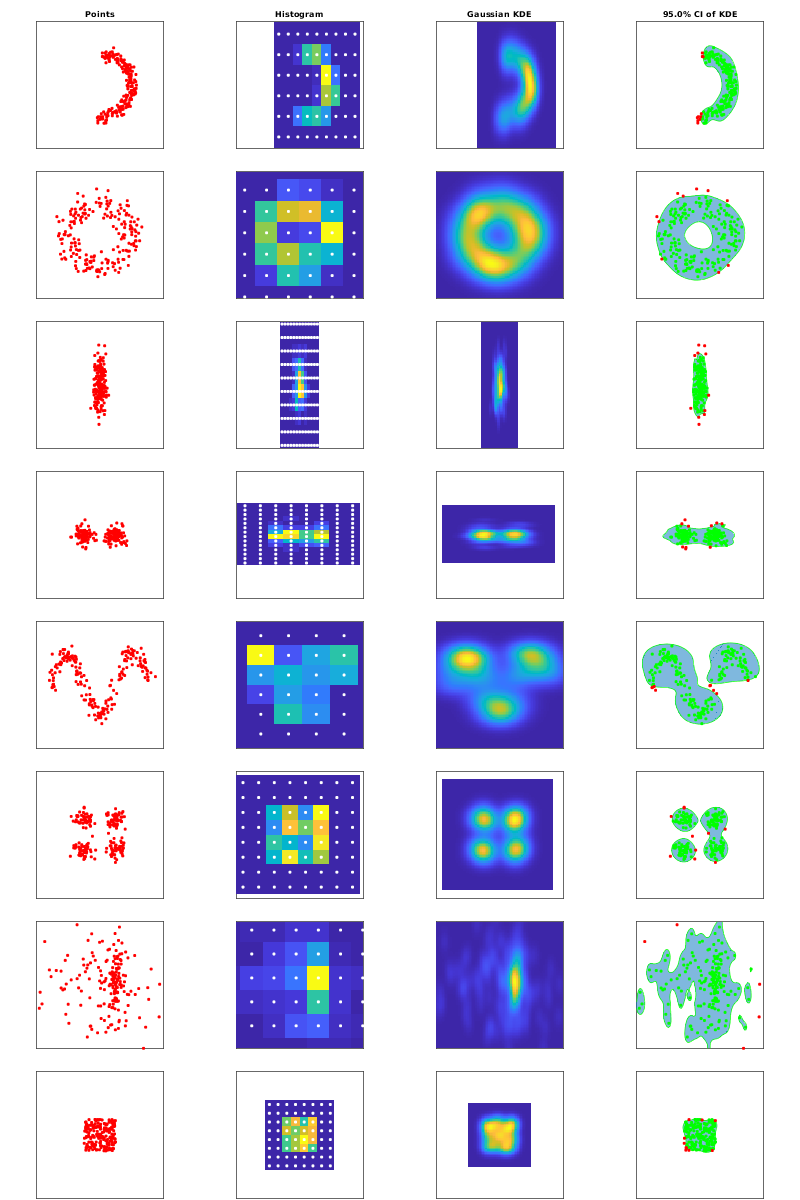

In [21]:
%%plot inline -s 800,1200 -r 150

tS = tightSubplot(8,4,[.05 .05 .01 .15]);
fs = 6;
for distN = 1:nTestDistributions
    points = testDistributions(distN, 200);

    tS.getSubplot(distN, 1);
    scatter(points(:,1),points(:,2),'r.');
    axis equal; box on; xlim([-2 2]); ylim([-2 2]);
    set(gca,'XTick',[],'YTick',[]);
    if distN == 1
        title('Points','FontSize',fs);
    end

    tS.getSubplot(distN, 2);
    [Xedges,Yedges] = autogridBivariate(points, 'BinCenters', false);
    [Xctrs,Yctrs] = autogridBivariate(points, 'BinCenters', true);
    N = histcounts2(points(:,1),points(:,2),Xedges,Yedges);
    pseudoColorImage(Xedges,Yedges,N'); hold on;
    [x,y] = meshgrid(Xctrs,Yctrs);
    scatter(x(:),y(:),'w.');
    axis equal; box on; xlim([-2 2]); ylim([-2 2]);
    set(gca,'XTick',[],'YTick',[]);
    if distN == 1
        title('Histogram','FontSize',fs);
    end

    tS.getSubplot(distN, 3);
    [Xctrs,Yctrs] = autogridBivariate(points,'Resolution',[.05,.05],'BinCenters',true);
    P = bivariateKDE(points, Xctrs, Yctrs,'ScaleBandwidth', .8);
    pseudoColorImage(Xctrs,Yctrs,P);
    axis equal; box on; xlim([-2 2]); ylim([-2 2]);
    set(gca,'XTick',[],'YTick',[]);
    if distN == 1
        title('Gaussian KDE','FontSize',fs);
    end

    tS.getSubplot(distN, 4);
    % alpha = 1 - .683; % Standard deviation
    alpha = 0.05;
    M = kdeConfidence(points, alpha, 'Resolution',[.05,.05],'ScaleBandwidth',0.8);
    h = plotContour(M,'FaceAlpha',0.5,'EdgeColor','g'); hold on;

    poly = contourToPolygon(M);
    in = inpolygon(points(:,1),points(:,2),poly(:,1),poly(:,2));
    scatter(points(find(in==1),1),points(find(in==1),2),'g.');
    scatter(points(find(in==0),1),points(find(in==0),2),'r.');

    axis equal; box on; xlim([-2 2]); ylim([-2 2]);
    set(gca,'XTick',[],'YTick',[]);
    if distN == 1
        title(sprintf('%.1f%% CI of KDE',100*(1-alpha)),'FontSize',fs);
    end
end

### Adaptive KDE

The idea here is to scale the Gaussian convolution kernel by the local density of the data. Here we first compute the Delaunay triangulation and the corresponding Voronoi diagram for the point sample. (The Voronoi diagram is, for each point in the data, the region of space for which that point is the nearest point.) We take the inverse of the area of each Voronoi cell as the local estimate of data density to use for scaling that point.

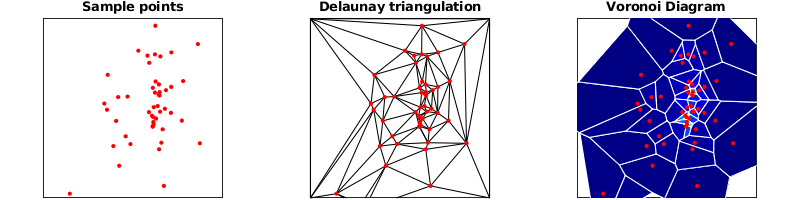

In [22]:
%plot inline -s 800,200 -r 150
% Example Delaunay triangulation and Voronoi diagram
Npoints = 50;
points = testDistributions(7, Npoints);

tS = tightSubplot(1,3);
tS.getSubplot(1);
scatter(points(:,1),points(:,2),'r.');
axis equal; box on; xlim([-2 2]); ylim([-2 2]);
set(gca,'XTick',[],'YTick',[]);
title('Sample points','FontSize',6);

tS.getSubplot(2);
framedPoints = cat(1,points,[2,2;-2,2;2,-2;-2,-2]); % Add a frame
dt = delaunayTriangulation(framedPoints);
triplot(dt,'k');hold on;
scatter(points(:,1),points(:,2),'r.');
axis equal; box on; xlim([-2 2]); ylim([-2 2]);
set(gca,'XTick',[],'YTick',[]);
title('Delaunay triangulation','FontSize',6);

tS.getSubplot(3);
[V,R] = voronoiDiagram(dt);
% Don't calculate areas for the framing points, which are unbounded
A = zeros(Npoints,1);
for n = 1:Npoints
    x = V(R{n},1);
    y = V(R{n},2);
    A(n) = polyarea(x,y);
    patch(x,y,(1/Npoints)/A(n),'EdgeColor','w'); hold on;
end
colormap(jet);
scatter(points(:,1),points(:,2),'r.');
axis equal; box on; xlim([-2 2]); ylim([-2 2]);
set(gca,'XTick',[],'YTick',[]);
title('Voronoi Diagram','FontSize',6);

In [23]:
%%file adaptiveBivariateKDE.m
%
% scaleBandwidth (optional)
%
function P = adaptiveBivariateKDE(points, Xlist, Ylist, varargin)

    scaleBandwidth = 1;
    for argN = 1:2:(nargin-3)
        if strcmp(varargin{argN},'ScaleBandwidth')
                scaleBandwidth = varargin{argN+1};
        end
    end

    % Frame points to prevent unbounded Voronoi cells
    frame = [max(points(:,1))+1,max(points(:,2))+1;...
         max(points(:,1))+1,min(points(:,2))-1;
         min(points(:,1))-1,max(points(:,2))+1;
         min(points(:,1))-1,min(points(:,2))-1];
    framedPoints = cat(1,points,frame); 
    % Calculate the Delaunay Triangulation
    dt = delaunayTriangulation(framedPoints);
    [V,R] = voronoiDiagram(dt);
    % Calculate areas of the Voronoi cells that correspond to each data point
    % Don't calculate areas for the framing points, which are unbounded
    A = zeros(size(points,1),1);
    for n = 1:size(points,1)
        x = V(R{n},1);
        y = V(R{n},2);
        A(n) = polyarea(x,y);
    end
    
    % Create a list of probe points, shape into a list
    [X,Y] = meshgrid(Xlist,Ylist);
    probePoints = [X(:),Y(:)];

    % Calculate the gaussian contribution from each data point to each probe point
    sigmaSq = scaleBandwidth*A';
    dSq = (probePoints(:,1) - points(:,1)').^2 + (probePoints(:,2) - points(:,2)').^2;
    G = 1./(sqrt(2*pi*sigmaSq)).*exp(-dSq./(2*sigmaSq));
    % Sum across data points
    Gtot = sum(G,2);
    
    % Reshape and normalize
    P = reshape(Gtot,size(X));
    P = P./sum(P(:));
end

Created file '/home/joe/Code/matlabTools/bivarConf/adaptiveBivariateKDE.m'.


In [24]:
%%file adaptiveKdeConfidence.m
%%
% adaptiveKdeConfidence.m
%
% Uses gaussian kernel density estimation to find a confidence region. 
% 
% varargin{:} - Specifies optional arguments to autogridBivariate.m
%
%%
function M = adaptiveKdeConfidence(points, alpha, varargin)
    [x, y] = autogridBivariate(points, 'BinCenters', true, varargin{:});
    P = adaptiveBivariateKDE(points,x,y,varargin{:}); 
    % M = contourBivariateDistribution(P, x, y, alpha);
    M = calibratedContour(P, x, y, alpha, points);
end

Created file '/home/joe/Code/matlabTools/bivarConf/adaptiveKdeConfidence.m'.


### Testing Adaptive KDE

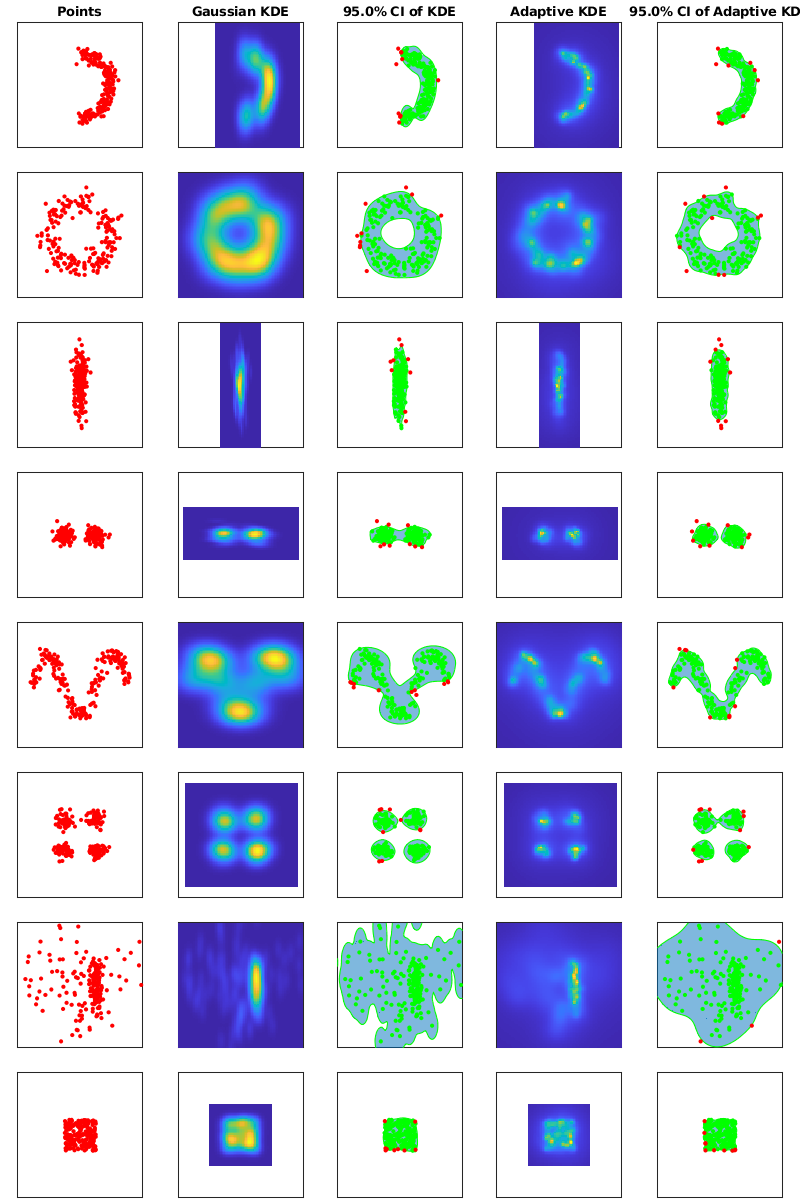

In [27]:
%plot inline -s 800,1200 -r 150

tS = tightSubplot(8,5,[.05 .05 .01 .15]);
fs = 6;
for distN = 1:nTestDistributions
    points = testDistributions(distN, 200);

    tS.getSubplot(distN, 1);
    scatter(points(:,1),points(:,2),'r.');
    axis equal; box on; xlim([-2 2]); ylim([-2 2]);
    set(gca,'XTick',[],'YTick',[]);
    if distN == 1
        title('Points','FontSize',fs);
    end

    tS.getSubplot(distN, 2);
    [Xctrs,Yctrs] = autogridBivariate(points,'Resolution',[.05,.05],'BinCenters',true);
    P = bivariateKDE(points, Xctrs, Yctrs,'ScaleBandwidth', .8);
    pseudoColorImage(Xctrs,Yctrs,P);
    axis equal; box on; xlim([-2 2]); ylim([-2 2]);
    set(gca,'XTick',[],'YTick',[]);
    if distN == 1
        title('Gaussian KDE','FontSize',fs);
    end

    tS.getSubplot(distN, 3);
    % alpha = 1 - 0.683; % Standard error
    alpha = 0.05;
    M = kdeConfidence(points, alpha, 'Resolution',[.05,.05],'ScaleBandwidth',0.8);
    h = plotContour(M,'FaceAlpha',0.5,'EdgeColor','g'); hold on;

    poly = contourToPolygon(M);
    in = inpolygon(points(:,1),points(:,2),poly(:,1),poly(:,2));
    scatter(points(find(in==1),1),points(find(in==1),2),'g.');
    scatter(points(find(in==0),1),points(find(in==0),2),'r.');

    axis equal; box on; xlim([-2 2]); ylim([-2 2]);
    set(gca,'XTick',[],'YTick',[]);
    if distN == 1
        title(sprintf('%.1f%% CI of KDE',100*(1-alpha)),'FontSize',fs);
    end


    tS.getSubplot(distN, 4);
    [Xctrs,Yctrs] = autogridBivariate(points,'Resolution',[.05,.05],'BinCenters',true);
    P = adaptiveBivariateKDE(points, Xctrs, Yctrs,'ScaleBandwidth', 1);
    pseudoColorImage(Xctrs,Yctrs,P);
    axis equal; box on; xlim([-2 2]); ylim([-2 2]);
    set(gca,'XTick',[],'YTick',[]);
    if distN == 1
        title('Adaptive KDE','FontSize',fs);
    end

    tS.getSubplot(distN, 5);
    % alpha = 1 - .683; % Standard deviation
    alpha = 0.05;
    M = adaptiveKdeConfidence(points, alpha, 'Resolution',[.05,.05],'ScaleBandwidth', 1);
    h = plotContour(M,'FaceAlpha',0.5,'EdgeColor','g'); hold on;

    poly = contourToPolygon(M);
    in = inpolygon(points(:,1),points(:,2),poly(:,1),poly(:,2));
    scatter(points(find(in==1),1),points(find(in==1),2),'g.');
    scatter(points(find(in==0),1),points(find(in==0),2),'r.');

    axis equal; box on; xlim([-2 2]); ylim([-2 2]);
    set(gca,'XTick',[],'YTick',[]);
    if distN == 1
        title(sprintf('%.1f%% CI of Adaptive KDE',100*(1-alpha)),'FontSize',fs);
    end
end